In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
import sys
sys.path.append("..")
sys.path.append("../..")

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
import copy
import pickle
import csv
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy import optimize

import darkhistory.physics as phys
from darkhistory.history.tla import get_history
from darkhistory.history import tla
import darkhistory.history.reionization as reion
from tqdm import tqdm_notebook as tqdm


import main
import config

In [3]:
output_dir = '/Users/gregoryridgway/Desktop/Junk/'
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/'

### Reionization Data

In [4]:
reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late','FlexKnot_early_1sig', 'FlexKnot_late_1sig', 'Tanh_early', 'Tanh_late', 'Tanh_early_1sig', 'Tanh_late_1sig']
)

def make_reion_interp_func(string, He_bump=False):
    Planck_data = []
    with open(input_dir+'reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)

    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]
        
        #I WebPlot Digitized poorly, so I re-zero
        if string == 'FlexKnot_late':
            Planck_data[26:,1] = 0
        elif string == 'Tanh_late':
            Planck_data[63:,1] = 0
            
        
    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac

    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]

    fac = 2
    if He_bump == False:
        Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
        fac = 1

    return interp1d(Planck_data[:,0], Planck_data[:,1], 
                    bounds_error=False, fill_value=(1+fac*phys.chi,0), kind='linear')

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
bump_interp = make_reion_interp_func('Tanh_late', True)

Text(0.5, 1.0, 'Planck 2018 Reionization Histories')

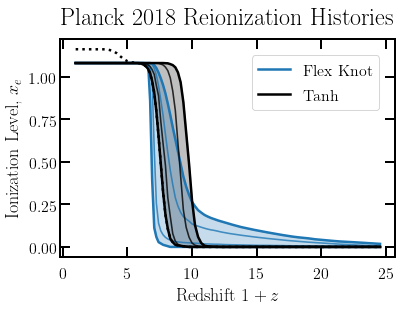

In [5]:
# Plot the different methods
reion_rs_list = 10**np.arange(0,np.log10(25), .01)
colors = {'FlexKnot_early': 'C0',
         'FlexKnot_late': 'C0',
         'FlexKnot_early_1sig': 'C0',
         'FlexKnot_late_1sig': 'C0',
         'Tanh_early': 'k',
         'Tanh_late': 'k',
         'Tanh_early_1sig': 'k',
         'Tanh_late_1sig': 'k'}

plt.figure()
# plt.loglog()
# plt.axis([1, 35, 1e-5, 1.5])
for string in reion_strings[2:]:
    if string[-4:] == 'late':
        plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string])
    else:
        if string[:-6] == 'FlexKnot':
            plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string], label='Flex Knot')
        elif string[-4:] == '1sig':
            plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string], linewidth='1.6', alpha=0.8)
        else:
            plt.plot(reion_rs_list, reion_interps[string](reion_rs_list), color=colors[string], label='Tanh')

plt.fill_between(reion_rs_list, 
                 reion_interps['Tanh_early'](reion_rs_list),
                reion_interps['Tanh_late'](reion_rs_list),
                color='k',
                alpha=0.25)

plt.fill_between(reion_rs_list, 
                 reion_interps['FlexKnot_early'](reion_rs_list),
                reion_interps['FlexKnot_late'](reion_rs_list),
                color='C0',
                alpha=0.25)

# Includes HeII reionization bump
plt.plot(reion_rs_list, bump_interp(reion_rs_list), color='k', linestyle=':')
            
plt.legend()
plt.xlabel(r'Redshift $1+z$')
plt.ylabel(r'Ionization Level, $x_e$')
plt.title(r'Planck 2018 Reionization Histories')

### Ly$\alpha$ data

In [6]:
ind = -7

z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[ind:]

new_mids=np.array([.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599])
mids = new_mids[ind:]

high_errs = np.array([.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15])
low_errs  = np.array([.22,.091,.15,.19,.14,.15,.14,.12,.16,.27,.19,.17,.073,.11,.091,.13])
sigs = low_errs[ind:]

Gaikwad_data = np.array([[1.1, .16], [1.05, .21], [1.2, .22]])
Gaikwad_rs   = np.array([6.4,6.6,6.8])

default_data = [
    np.concatenate((rs_entries[:-2], Gaikwad_rs)),
    (
        np.concatenate((mids[:-2], Gaikwad_data[:,0])),
        np.concatenate((high_errs[ind:-2], Gaikwad_data[:,1]))
    )
]

Text(0.5, 0, 'Redshift, $1+z$')

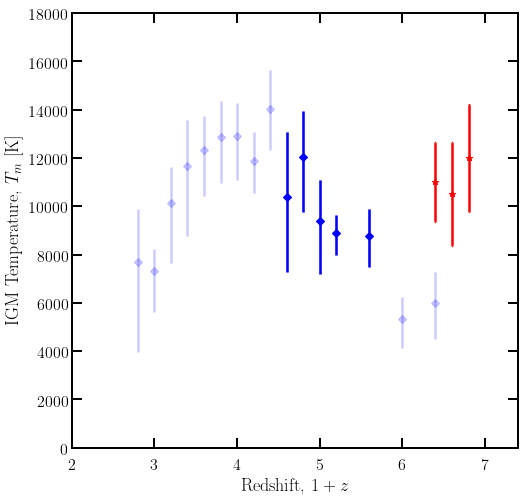

In [7]:
plt.figure(figsize=(8,8))

plt.axis([2,7.4,0,1.8e4])
plt_ind = -7
plotline1, cap1, barlinecols1 = plt.errorbar(1+z_entries, new_mids*1e4, yerr=high_errs*1e4, 
             uplims=True, fmt='D', alpha=0.2, color='blue', capsize=0.1, capthick=0.1)
plotline2, cap2, barlinecols2 = plt.errorbar(1+z_entries, new_mids*1e4, yerr=low_errs*1e4,  
             lolims=True, fmt=',', alpha=0.2, color='blue', capsize=0.1, capthick=0.1)

plotline3, cap3, barlinecols3 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2]*1e4, yerr=high_errs[plt_ind:-2]*1e4, 
             uplims=True, fmt='D', color='blue', capsize=0.1, capthick=0.1)
plotline4, cap4, barlinecols4 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2]*1e4, yerr=low_errs[plt_ind:-2]*1e4,  
             lolims=True, fmt=',', color='blue', capsize=0.1, capthick=0.1)


plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0]*1e4, yerr=Gaikwad_data[:,1]*1e4,  
             lolims=True, fmt='*', color='red', capsize=0.9, capthick=0.9)
plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0]*1e4, yerr=Gaikwad_data[:,1]*1e4,  
             uplims=True, fmt='*', color='red', capsize=0.9, capthick=0.9)

plt.ylabel('IGM Temperature, $T_m$ [K]')
plt.xlabel('Redshift, $1+z$')

### Functions for constraints

In [11]:
max_chisq = 10.1522
def find_param_guess(mDM, log10guess, inc, data, heat_switch=False, 
                     reion_method='FlexKnot_early',pri = 'elec', DM_process = 'decay', 
                     DeltaT=24665*phys.kB, alpha_bk=0.57, HeIIIcheck_switch=False):
    """
    Parameters
    ----------
    inc : float
        amount by which to increment the log10(parameter)
    DeltaT : float
        photoheating parameter, set to best fit value in the absence of DM
    alpha_bk : float
        photoheating parameter, set to best fit value in the absence of DM
    
    """
    below_target = False
    above_target = False
    chisq_list = []
    log10params = [log10guess]

    while (
        not below_target or not above_target
    ):

        param = 10**log10params[-1]
        print('log10param: '+str(log10params[-1]))
        if DM_process=='pwave':
            sign=-1.0
            struct_boost = phys.struct_boost_func(model='pwave_NFW_no_subs')
        else:
            sign = 1.0
            struct_boost = None

        base_hist = main.evolve(
            primary=pri+'_delta',
            DM_process=DM_process, mDM=mDM, lifetime=param, sigmav=param,
            reion_switch=True, reion_rs=35, helium_TLA=True,
            xe_reion_func = reion_interps[reion_method],
            start_rs = 3e3, end_rs=4.3, DeltaT = DeltaT, 
            alpha_bk=alpha_bk, heat_switch=heat_switch,
            coarsen_factor=12, backreaction=True, 
            compute_fs_method='He', mxstep=1000, rtol=1e-4,
            use_tqdm=True, cross_check = False,
            struct_boost=struct_boost, HeIIIcheck_switch=HeIIIcheck_switch
        )
        
        if not heat_switch:
            Tm_interp = interp1d(base_hist['rs'], base_hist['Tm']/phys.kB*1e-4)
            diff = Tm_interp(data[0]) - data[1][0]
            diff[diff<0] = 0
            chisq = sum((diff/data[1][1])**2)
        else:
            fs = make_fs(base_hist)
            alpha_list = np.arange(-0.5,1.5,0.1)
            data = find_optimum(alpha_list, init=19, mDM=mDM, lifetime=param, sigmav=param, fs=fs, DM_process=DM_process)
            chisq = data[1][-1]
        
        chisq_list.append(chisq)
        print('Test Statistic: {:03.3e}'.format(chisq))

        nan_flag = np.any(np.isnan(base_hist['Tm']))
        if nan_flag:
            print('NAN! increasing heating rate.')
            log10params.append(log10params[-1]-inc*sign)
        elif chisq < max_chisq:
            below_target = True
            log10params.append(log10params[-1]-inc*sign)
        elif chisq > max_chisq:
            above_target = True
            log10params.append(log10params[-1]+inc*sign)

    param_interp = interp1d(chisq_list, log10params[:-1])
    return param_interp(max_chisq), chisq_list, log10params

### Functions for photoheated constraints

In [9]:
rs_vec = 10**np.arange(np.log10(2.9e3), np.log10(4.55), -.01)

#Given DeltaT and alpha, return the temperature in 10^-4 K
def get_his(DeltaT, alpha, mDM=None, lifetime=None, sigmav=None, fs=[None, None, None, None], DM_process='decay'):
    struct_boost = None
    if (sigmav is not None):# & (): !!!struct_boost is mistakenly folded into the fs
        struct_boost = phys.struct_boost_func(model='pwave_NFW_no_subs')
    elif lifetime is not None:
        struct_boost = None
    else:
        struct_boost = None
        DM_process   = None

    tmp = tla.get_history(
        rs_vec,
        DM_process = DM_process, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
        struct_boost = struct_boost,
        f_H_ion=fs[0], f_He_ion=fs[1], f_H_exc=fs[2], f_heating=fs[3],
        reion_switch=True, reion_rs=35, reion_method=None,
        heat_switch=True, DeltaT = DeltaT, alpha_bk=alpha,
        xe_reion_func=reion_interps[reion_method], helium_TLA=True
    )
    return interp1d(rs_vec, tmp[:,0]/phys.kB*1e-4)

#Given DeltaT and alpha, find (two-sided) chi^2
def get_chisq(var, mDM=None, lifetime=None, sigmav=None, fs=[None, None, None, None], DM_process='decay'):
    DeltaT = var[0]
    alpha=var[1]
    terp = get_his(DeltaT, alpha, mDM=mDM, lifetime=lifetime, sigmav=sigmav, fs=fs, DM_process = DM_process)
    return sum((terp(default_data[0])-default_data[1][0])**2/default_data[1][1]**2)

#Given alpha, optimize DeltaT
def optimize_DeltaT(alpha, tol, mDM=None, lifetime=None, sigmav=None, fs=[None, None, None, None], DM_process='decay'):
    def f(DeltaT):
        return get_chisq([DeltaT,alpha], mDM=mDM, lifetime=lifetime, sigmav=sigmav, fs=fs, DM_process = DM_process)

    return optimize.minimize_scalar(
        f, method='bounded', bounds=[0*phys.kB, 5e4*phys.kB], options={'xatol': tol}
    )

def find_optimum(alpha_list, init, tol=0.5, mDM=None, lifetime=None, sigmav=None, fs=[None, None, None, None], DM_process='decay', output=False):
    datums = [None for a in alpha_list]
    check_above = False
    check_below = False

    #Initialization Step
    j = init
    out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav, fs=fs, DM_process = DM_process)
    datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]
    count = 0
    
    #Search higher alpha
    while not check_above:
        count = count+1
        #At this point, you know the optimal value is above
        if count>1:
            check_below = True

        j = j+1
        out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav, fs=fs, DM_process = DM_process)
        datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]
        if output:
            print(datums[j])

        if datums[j][2] > datums[j-1][2]:
            check_above=True
            j = j-1
            break
        elif j==alpha_list.size-1:
            #if output:
            print('Reached maximum alpha!', datums[j])
            return np.array([datums[j],datums[j],datums[j]])
            

    #Search lower alpha
    while not check_below:
        j = j-1
        out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav, fs=fs, DM_process = DM_process)
        datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]

        if output:
            print(datums[j])
        if datums[j][2] > datums[j+1][2]:
            check_below=True
            j = j+1
        elif j==0:
            #if output:
            print('Reached minimum alpha!', datums[j])
            return np.array([datums[j],datums[j],datums[j]])

    print('Best value: ', datums[j])
    return np.array([datums[j-1], datums[j], datums[j+1]])


#Make the f functions
def make_fs(hist, pkl = False):
    channels = {'heat', 'H ion', 'He ion', 'exc'}
    f_interps = {chan: interp1d(
        hist['rs'],
        hist['f']['low'][chan]+hist['f']['high'][chan],
        bounds_error=False,
        fill_value=(
            (hist['f']['low'][chan]+hist['f']['high'][chan])[-1],
            (hist['f']['low'][chan]+hist['f']['high'][chan])[0]
        )
    ) for chan in channels}

    def f_Hion(rs, xHI, xHeI, xHeII):
        return f_interps['H ion'](rs)
    def f_Heion(rs, xHI, xHeI, xHeII):
        return f_interps['He ion'](rs)
    def f_exc(rs, xHI, xHeI, xHeII):
        return f_interps['exc'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_interps['heat'](rs)
     
    if not pkl:
        return [f_Hion, f_Heion, f_exc, f_heat]
    else:
        return f_interps

## Generate Constraints

This function below will write out all of the f interpolation functions and save them in output_dir

In [10]:
constr_str = 'conservative' #'conservative' or 'photoheated'
m_inc   = 0.1
tau_inc = 0.25
guess_funcs = pickle.load(open('guess_funcs.p', 'rb'))

In [12]:
%autoreload
# Check that a valid type of constraint has been chosen
if constr_str == 'conservative':
    heat_switch = False
    print("deriving `conservative' constraints")
elif constr_str == 'photoheated':
    heat_switch = True
    print("deriving `photoheated' constraints")
else:
    print('Invalid constr_str, exiting...')
    sys.exit()

#Loop through different types of constraints
for DM_process in ['decay']:#, 'pwave']:
    for pri in ['elec']:#, 'phot']:
        for reion_method in ['Tanh_early']:#, 'Tanh_late', 'FlexKnot_early', 'FlexKnot_late']:

            if reion_method[-4:] == 'late':
                time_str = 'late'
            else:
                time_str = 'early'
            
            if DM_process == 'decay':
                sign=1
            else:
                sign=-1
                
#             string = pri+'_'+DM_process+'_'+reion_method[:4]+'_'+time_str
            key = constr_str+'_'+reion_method+'_'+pri+'_'+DM_process

            if pri=='phot':
                log10m = np.arange(4.01, 12.76, m_inc)
            else:
                log10m = np.arange(6.01, 12.76, m_inc)
            
            max_chisq_list = np.zeros_like(log10m)
            data = [[None for k in max_chisq_list], [None for k in max_chisq_list]]
            for i, log10mDM in tqdm(enumerate(log10m)):
                    print('****** log10(mDM): ', log10mDM, ' ******')
                    mDM = 10**log10mDM
                    
                    log10guess = guess_funcs[key](log10mDM)

                    max_chisq_list[i], tmp_chisq_list, tmp_param_list  = find_param_guess(
                        mDM, log10guess, tau_inc, default_data, heat_switch=heat_switch,
                        DM_process = DM_process, HeIIIcheck_switch=True,
                        reion_method=reion_method, pri=pri
                    )
                    data[0][i] = tmp_chisq_list
                    data[1][i] = tmp_param_list
                    pickle.dump(data, open(output_dir+'CrossCheckHeIII_'+constr_str+'_'+reion_method+'_'+pri+'_'+DM_process+'.dat','wb'))

            #pickle.dump(data, open(output_dir+'dataFreeStream_'+constr_str+'_'+reion_method+'_'+pri+'_'+DM_process+'.dat','wb'))
            pickle.dump(data, open(output_dir+'CrossCheckHeIII_'+constr_str+'_'+reion_method+'_'+pri+'_'+DM_process+'.dat','wb'))

deriving `conservative' constraints
****** log10(mDM):  6.01  ******
log10param: 23.14150934193324
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Test Statistic: 5.559e+00
log10param: 22.89150934193324



Test Statistic: 2.218e+02
****** log10(mDM):  6.109999999999999  ******
log10param: 24.867238517000896



Test Statistic: 6.627e-02
log10param: 24.617238517000896



Test Statistic: 1.013e+02
****** log10(mDM):  6.209999999999999  ******
log10param: 25.083567382542135



Test Statistic: 6.225e-02
log10param: 24.833567382542135



Test Statistic: 9.452e+01
****** log10(mDM):  6.309999999999999  ******
log10param: 25.05353322863178



Test Statistic: 9.567e+00
log10param: 24.80353322863178



Test Statistic: 2.796e+02
****** log10(mDM):  6.409999999999998  ******
log10param: 25.09610841995737



Test Statistic: 5.521e+00
log10param: 24.84610841995737



Test Statistic: 2.297e+02
****** log10(mDM):  6.509999999999998  ******
log10param: 25.076444235968182



Test Statistic: 6.680e+00
log10param: 24.826444235968182



Test Statistic: 2.431e+02
****** log10(mDM):  6.609999999999998  ******
log10param: 25.03011528784082



Test Statistic: 6.984e+00
log10param: 24.78011528784082



Test Statistic: 2.454e+02
****** log10(mDM):  6.709999999999997  ******
log10param: 24.982034071216162



Test Statistic: 6.191e+00
log10param: 24.732034071216162



Test Statistic: 2.345e+02
****** log10(mDM):  6.809999999999997  ******
log10param: 24.924105272469102



Test Statistic: 7.520e+00
log10param: 24.674105272469102



Test Statistic: 2.502e+02
****** log10(mDM):  6.909999999999997  ******
log10param: 24.849141359761077



Test Statistic: 6.453e+00
log10param: 24.599141359761077



Test Statistic: 2.365e+02
****** log10(mDM):  7.009999999999996  ******
log10param: 24.776539941661



Test Statistic: 6.872e+00
log10param: 24.526539941661



Test Statistic: 2.413e+02
****** log10(mDM):  7.109999999999996  ******
log10param: 24.68698836150051



Test Statistic: 5.386e+00
log10param: 24.43698836150051



Test Statistic: 2.221e+02
****** log10(mDM):  7.2099999999999955  ******
log10param: 24.601178301191915



Test Statistic: 6.000e+00
log10param: 24.351178301191915



Test Statistic: 2.303e+02
****** log10(mDM):  7.309999999999995  ******
log10param: 24.52567421232769



Test Statistic: 4.765e+00
log10param: 24.27567421232769



Test Statistic: 2.140e+02
****** log10(mDM):  7.409999999999995  ******
log10param: 24.462627022141188



Test Statistic: 3.196e+00
log10param: 24.212627022141188



Test Statistic: 1.905e+02
****** log10(mDM):  7.5099999999999945  ******
log10param: 24.40693666875153



Test Statistic: 4.655e+00
log10param: 24.15693666875153



Test Statistic: 2.132e+02
****** log10(mDM):  7.609999999999994  ******
log10param: 24.479198853575802



Test Statistic: 1.436e-01
log10param: 24.229198853575802



Test Statistic: 1.073e+02
****** log10(mDM):  7.709999999999994  ******
log10param: 24.53858709037776



Test Statistic: 8.821e-03
log10param: 24.28858709037776



Test Statistic: 7.855e+01
****** log10(mDM):  7.809999999999993  ******
log10param: 24.571964337974382



Test Statistic: 1.344e-01
log10param: 24.321964337974382


../darkhistory/history/tla.py:895: RuntimeWarning: divide by zero encountered in arctanh
  _init_cond[3] = np.arctanh(2/chi *(_init_cond[3] - chi/2))
../darkhistory/physics.py:131: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(omega_rad*rs**4 + omega_m*rs**3 + omega_lambda)
../darkhistory/physics.py:618: RuntimeWarning: invalid value encountered in log
  gauss_corr_1 = -0.14*np.exp(-((np.log(rs) - 7.28)/0.18)**2)
../darkhistory/physics.py:619: RuntimeWarning: invalid value encountered in log
  gauss_corr_2 = 0.079*np.exp(-((np.log(rs) - 6.73)/0.33)**2)
../darkhistory/physics.py:562: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(2 * np.pi * me * T_rad)
../darkhistory/low_energy/lowE_deposition.py:160: RuntimeWarning: invalid value encountered in greater
  ) for rate in rates
../darkhistory/low_energy/lowE_photons.py:242: RuntimeWarning: invalid value encountered in greater
  ) for rate in rates
../darkhistory/history/tla.py:962: RuntimeWarning: in


Test Statistic: nan
NAN! increasing heating rate.
log10param: 24.071964337974382


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less



Test Statistic: nan
NAN! increasing heating rate.
log10param: 23.821964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 23.571964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 23.321964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 23.071964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 22.821964337974382


../darkhistory/physics.py:568: RuntimeWarning: overflow encountered in exp
  * np.exp(-rydberg/4/T_rad) * alpha_recomb(T_rad, 'HI')



Test Statistic: nan
NAN! increasing heating rate.
log10param: 22.571964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 22.321964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 22.071964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 21.821964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 21.571964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 21.321964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 21.071964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 20.821964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 20.571964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 20.321964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 20.071964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 19.821964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 19.571964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 19.321964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 19.071964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 18.821964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 18.571964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 18.321964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 18.071964337974382


../darkhistory/history/tla.py:334: RuntimeWarning: overflow encountered in cosh
  return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 17.821964337974382


nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 17.571964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 17.321964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 17.071964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in 

nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 16.571964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 16.321964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 16.071964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 15.821964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 15.571964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 15.321964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 15.071964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...


../darkhistory/history/tla.py:294: RuntimeWarning: overflow encountered in double_scalars
  return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
../darkhistory/history/tla.py:301: RuntimeWarning: overflow encountered in double_scalars
  )/ (3/2 * nH * (1 + chi + xe))
../darkhistory/history/tla.py:301: RuntimeWarning: invalid value encountered in double_scalars
  )/ (3/2 * nH * (1 + chi + xe))


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 14.821964337974382



Test Statistic: nan
NAN! increasing heating rate.
log10param: 14.571964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...


../darkhistory/history/tla.py:294: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
../darkhistory/history/tla.py:294: RuntimeWarning: invalid value encountered in double_scalars
  return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
../darkhistory/history/tla.py:301: RuntimeWarning: divide by zero encountered in double_scalars
  )/ (3/2 * nH * (1 + chi + xe))
../darkhistory/physics.py:506: RuntimeWarning: divide by zero encountered in double_scalars
  / (1 + 0.6703 * (conv_fac*T_m)**0.5300)


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 14.321964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 14.071964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 13.821964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 13.571964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 13.321964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 13.071964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 12.821964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 12.571964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 12.321964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 12.071964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...

Test Statistic: nan
NAN! increasing heating rate.
log10param: 11.821964337974382


nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...
nans in solution, resolving...


KeyboardInterrupt: 

In [72]:
ind=10
print(log10m[ind])
data[0][ind] = np.array([1.9, 170])
data[1][ind] = np.array([25.23062660083575, 24.98062660083575, 0])

8.51


In [73]:
pickle.dump(data, open(output_dir+'CrossCheck_'+constr_str+'_'+reion_method+'_'+pri+'_'+DM_process+'.dat','wb'))

In [34]:
tmp_param_list

[array(21.73988399), 21.48988399027368, 21.73988399027368]

In [31]:
# Check that a valid type of constraint has been chosen
if constr_str == 'conservative':
    heat_switch = False
    print("deriving `conservative' constraints")
elif constr_str == 'photoheated':
    heat_switch = True
    print("deriving `photoheated' constraints")
else:
    print('Invalid constr_str, exiting...')
    sys.exit()

#Loop through different types of constraints
for DM_process in ['decay']:#, 'pwave']:
    for pri in ['elec']:#, 'phot']:
        for reion_method in ['Tanh_early']:#, 'Tanh_late', 'FlexKnot_early', 'FlexKnot_late']:

            if reion_method[-4:] == 'late':
                time_str = 'late'
            else:
                time_str = 'early'
            
            if DM_process == 'decay':
                sign=1
            else:
                sign=-1
                
#             string = pri+'_'+DM_process+'_'+reion_method[:4]+'_'+time_str
            key = constr_str+'_'+reion_method+'_'+pri+'_'+DM_process

            if pri=='phot':
                log10m = np.arange(4.01, 12.76, m_inc)
            else:
                log10m = np.arange(6.01, 12.76, m_inc)
            
            max_chisq_list = np.zeros_like(log10m)
            data = [[None for k in max_chisq_list], [None for k in max_chisq_list]]
            for i, log10mDM in enumerate(log10m):
                    print('****** log10(mDM): ', log10mDM, ' ******')
                    mDM = 10**log10mDM
                    
                    log10guess = guess_funcs[key](log10mDM)

                    max_chisq_list[i], tmp_chisq_list, tmp_param_list  = find_param_guess(
                        mDM, log10guess, tau_inc, default_data, heat_switch=heat_switch,
                        DM_process = DM_process, HeIIIcheck_switch=False,
                        reion_method=reion_method, pri=pri
                    )
                    data[0][i] = tmp_chisq_list
                    data[1][i] = tmp_param_list

            pickle.dump(data, open(output_dir+'unCrossCheck_'+constr_str+'_'+reion_method+'_'+pri+'_'+DM_process+'.dat','wb'))

deriving `conservative' constraints
****** log10(mDM):  6.01  ******
log10param: 23.14150934193324


TypeError: evolve() got an unexpected keyword argument 'HeIIIcheck_switch'